In [1]:
%%time

import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

from fast_hdbscan.numba_kdtree import kdtree_to_numba
from fast_hdbscan.numba_kdtree import parallel_tree_query
from sklearn.neighbors import KDTree

CPU times: user 11.3 s, sys: 367 ms, total: 11.6 s
Wall time: 9.27 s


In [2]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"

In [3]:
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

In [4]:
graph.cardinalities.describe()

count    304554.000000
mean          6.751085
std           2.060782
min           1.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          82.000000
Name: cardinalities, dtype: float64

In [5]:
from core.cluster_validation import print_distance, generate_neigbhourhood_groups

In [6]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [7]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')



X_train = X_train[X_train.index >= 0]



spatial_lag = 2


# lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}_lag_{spatial_lag}.parquet')

lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/unprocessed_context_chars_{region_id}_lag_{spatial_lag}.parquet')



# X_train = X_train.join(lag[[c for c in lag.columns if '_median' in c]], how='inner')
X_train = X_train.join(lag, how='inner')


In [8]:
for c in X_train.columns:
    X_train[c] = X_train[c].clip(*np.percentile(X_train[c], [25, 75]))

In [9]:
vals = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)

vals = np.nan_to_num(X_train)
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)


# X_train = X_train.clip(-10, 10)

In [10]:
X_train.describe()

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,ssbCCM,ssbCCD,...,ltkOri_higher,ltkWNB_lower,ltkWNB_median,ltkWNB_higher,likWBB_lower,likWBB_median,likWBB_higher,sdsAre_lower,sdsAre_median,sdsAre_higher
count,2.990640e+05,2.990640e+05,299064.0,2.990640e+05,2.990640e+05,2.990640e+05,2.990640e+05,2.990640e+05,2.990640e+05,2.990640e+05,...,2.990640e+05,2.990640e+05,2.990640e+05,2.990640e+05,2.990640e+05,2.990640e+05,2.990640e+05,2.990640e+05,2.990640e+05,2.990640e+05
mean,2.138300e-16,9.741143e-17,0.0,-9.537767e-16,-1.547179e-16,-4.789791e-17,-1.548205e-14,-1.486356e-15,-8.420149e-17,8.382135e-17,...,-3.094357e-16,-9.001767e-16,-5.390416e-16,-1.832285e-16,3.124769e-16,-2.995520e-16,-4.827806e-16,2.440513e-16,-4.268997e-16,-2.794045e-16
std,1.000002e+00,1.000002e+00,0.0,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,9.999465e-01,9.999465e-01,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.171204e+00,-1.227228e+00,0.0,-1.323301e+00,-9.560473e-01,-1.025796e+00,-1.408986e+00,-1.259402e+00,-1.216599e+00,-5.934344e-01,...,-1.231474e+00,-1.078034e+00,-1.122950e+00,-1.198521e+00,-1.136820e+00,-1.204462e+00,-1.243431e+00,-1.015741e+00,-1.020150e+00,-1.056317e+00
25%,-1.171200e+00,-1.227222e+00,0.0,-1.323301e+00,-9.560473e-01,-1.025796e+00,-1.408952e+00,-1.259400e+00,-5.121844e-01,-5.881004e-01,...,-1.231474e+00,-1.078034e+00,-1.122950e+00,-1.198521e+00,-1.136820e+00,-1.204462e+00,-1.243431e+00,-1.015741e+00,-1.020150e+00,-1.056317e+00
50%,-1.021714e-01,-3.136307e-02,0.0,1.841764e-01,1.502397e-01,-3.571189e-01,6.056801e-01,6.597197e-02,-1.797281e-01,-2.977174e-01,...,1.279235e-02,-2.832950e-01,-1.841563e-01,-6.601486e-02,-1.664405e-01,-3.720930e-02,1.411818e-02,-3.715764e-01,-3.691832e-01,-3.181395e-01
75%,1.317557e+00,1.263988e+00,0.0,1.130701e+00,1.256527e+00,1.425584e+00,9.034640e-01,1.193821e+00,1.684496e-01,2.447843e-01,...,1.214326e+00,1.381869e+00,1.307293e+00,1.265496e+00,1.304499e+00,1.242575e+00,1.225427e+00,1.435341e+00,1.426268e+00,1.389537e+00
max,1.317569e+00,1.263989e+00,0.0,1.130707e+00,1.256527e+00,1.425639e+00,9.034640e-01,1.193821e+00,4.528512e+01,5.575523e+01,...,1.214326e+00,1.381896e+00,1.307293e+00,1.265496e+00,1.304523e+00,1.242575e+00,1.225427e+00,1.435344e+00,1.426268e+00,1.389561e+00


In [11]:
tess_groups = generate_neigbhourhood_groups(tessellation,
                                            buffer=200,
                                         include_random_sample=True,
                                         random_sample_size=1_000)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]
tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train)), index=X_train.index)
    .loc[tess_groups.index]
    .values
)

def check_score(data, example_clusters):
    groups = example_clusters[example_clusters.index.isin(data.index)]
    groups_ilocs = (
        pd.Series(np.arange(len(data)), index=data.index).loc[groups.index].values
    )
    return davies_bouldin_score(data.iloc[groups_ilocs], groups.values)

In [12]:
# tessellation.loc[tess_groups.index].explore()

In [13]:
from core.cluster_validation import print_distance
print_distance( pd.DataFrame(X_train.loc[tess_groups.index]).groupby(tess_groups.values).mean(), metric='euclidean')

,holyne,housing estate,josefov,karlin,mala strana,malesice,nusle,random,stare mesto,vinohrady
holyne,0.000000,13.660231,14.729026,17.117709,12.920245,20.600708,11.314842,8.464004,13.579621,16.209511
housing estate,13.660231,0.000000,13.602019,15.998414,14.935844,19.493793,11.515509,9.902267,14.262660,16.883219
josefov,14.729026,13.602019,0.000000,13.567390,10.393775,24.436127,11.046185,14.398508,6.576643,9.944295
karlin,17.117709,15.998414,13.567390,0.000000,16.218562,18.886341,15.280356,13.830988,13.914555,10.794817
mala strana,12.920245,14.935844,10.393775,16.218562,0.000000,22.114176,9.813651,13.666840,7.592299,14.101026
malesice,20.600708,19.493793,24.436127,18.886341,22.114176,0.000000,18.979956,15.241626,23.294010,23.070371
nusle,11.314842,11.515509,11.046185,15.280356,9.813651,18.979956,0.000000,10.237869,10.647553,14.396936
random,8.464004,9.902267,14.398508,13.830988,13.666840,15.241626,10.237869,0.000000,14.159710,15.338104
stare mesto,13.579621,14.262660,6.576643,13.914555,7.592299,23.294010,10.647553,14.159710,0.000000,11.114330
vinohrady,16.209511,16.883219,9.944295,10.794817,14.101026,23.070371,14.396936,15.338104,11.114330,0.000000


In [15]:
from scipy.spatial.distance import pdist
for i, g in X_train.loc[tess_groups.index].groupby(tess_groups.values):
    print(i, np.median(pdist(g)))

holyne 16.867323946525687
housing estate 14.537036995995132
josefov 11.14589249890372
karlin 11.17750023551571
mala strana 13.412508277525806
malesice 13.911323149855836
nusle 16.460632309871052
random 21.220313802360415
stare mesto 11.832032725927709
vinohrady 10.202987142069015


In [16]:
# training_data = X_train.loc[tess_groups.index]
# tess_groups_ilocs = (
#     pd.Series(np.arange(len(training_data)), index=training_data.index)
#     .loc[tess_groups.index]
#     .values
# )
# training_data.shape

In [17]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from core.cluster_validation import get_linkage_matrix

In [18]:
q1 = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")
clustering_graph = q1.higher_order(k=3, lower_order=True, diagonal=True).subgraph(X_train.index.values)

In [19]:
graph_labels = q1.subgraph(X_train.index.values).component_labels
graph_labels.value_counts()

component labels
776    60555
452    25177
754    17243
99     15583
726    13382
       ...  
247        1
727        1
249        1
250        1
161        1
Name: count, Length: 919, dtype: int64

In [20]:
clustering_graph = clustering_graph.subgraph(graph_labels[graph_labels == 776].index.values)

In [21]:
core_ids = clustering_graph.unique_ids
clustering_graph = clustering_graph.transform('B').sparse

In [22]:
training_data = X_train[X_train.index.isin(core_ids)]

In [23]:
to_drop = ['stcSAl',
 'stbSAl',
 'ltkOri',
 'stbOri',
 'stcOri',
 'stbCeA',
 'sdsSWD',
 'mtbAli']

In [24]:
# training_data = training_data[[c for c in training_data.columns if 'Ori' not in c]]
# training_data = training_data[[c for c in training_data.columns if 'SAl' not in c]]
# training_data = training_data[[c for c in training_data.columns if 'CeA' not in c]]
# training_data = training_data[[c for c in training_data.columns if 'SWD' not in c]]
# training_data = training_data[[c for c in training_data.columns if 'Ali' not in c]]

# training_data = training_data[[c for c in training_data.columns if '_' not in c]]


In [36]:
t1 = training_data[[c for c in training_data.columns if '_' not in c]]
t2 = training_data[[c for c in training_data.columns if '_median' in c]]

training_data = t1.join(t2)

In [37]:
training_data.shape

(60555, 124)

In [38]:
# training_data = training_data[[c for c in training_data.columns if '_' not in c]]
# training_data.shape

In [39]:
%%time
clusterer = AgglomerativeClustering(linkage='ward',
                                    connectivity=clustering_graph, 
                                    compute_full_tree=True, compute_distances=True)
model = clusterer.fit(training_data)

CPU times: user 9.9 s, sys: 59.9 ms, total: 9.96 s
Wall time: 9.96 s


In [40]:
linkage_matrix = get_linkage_matrix(model)

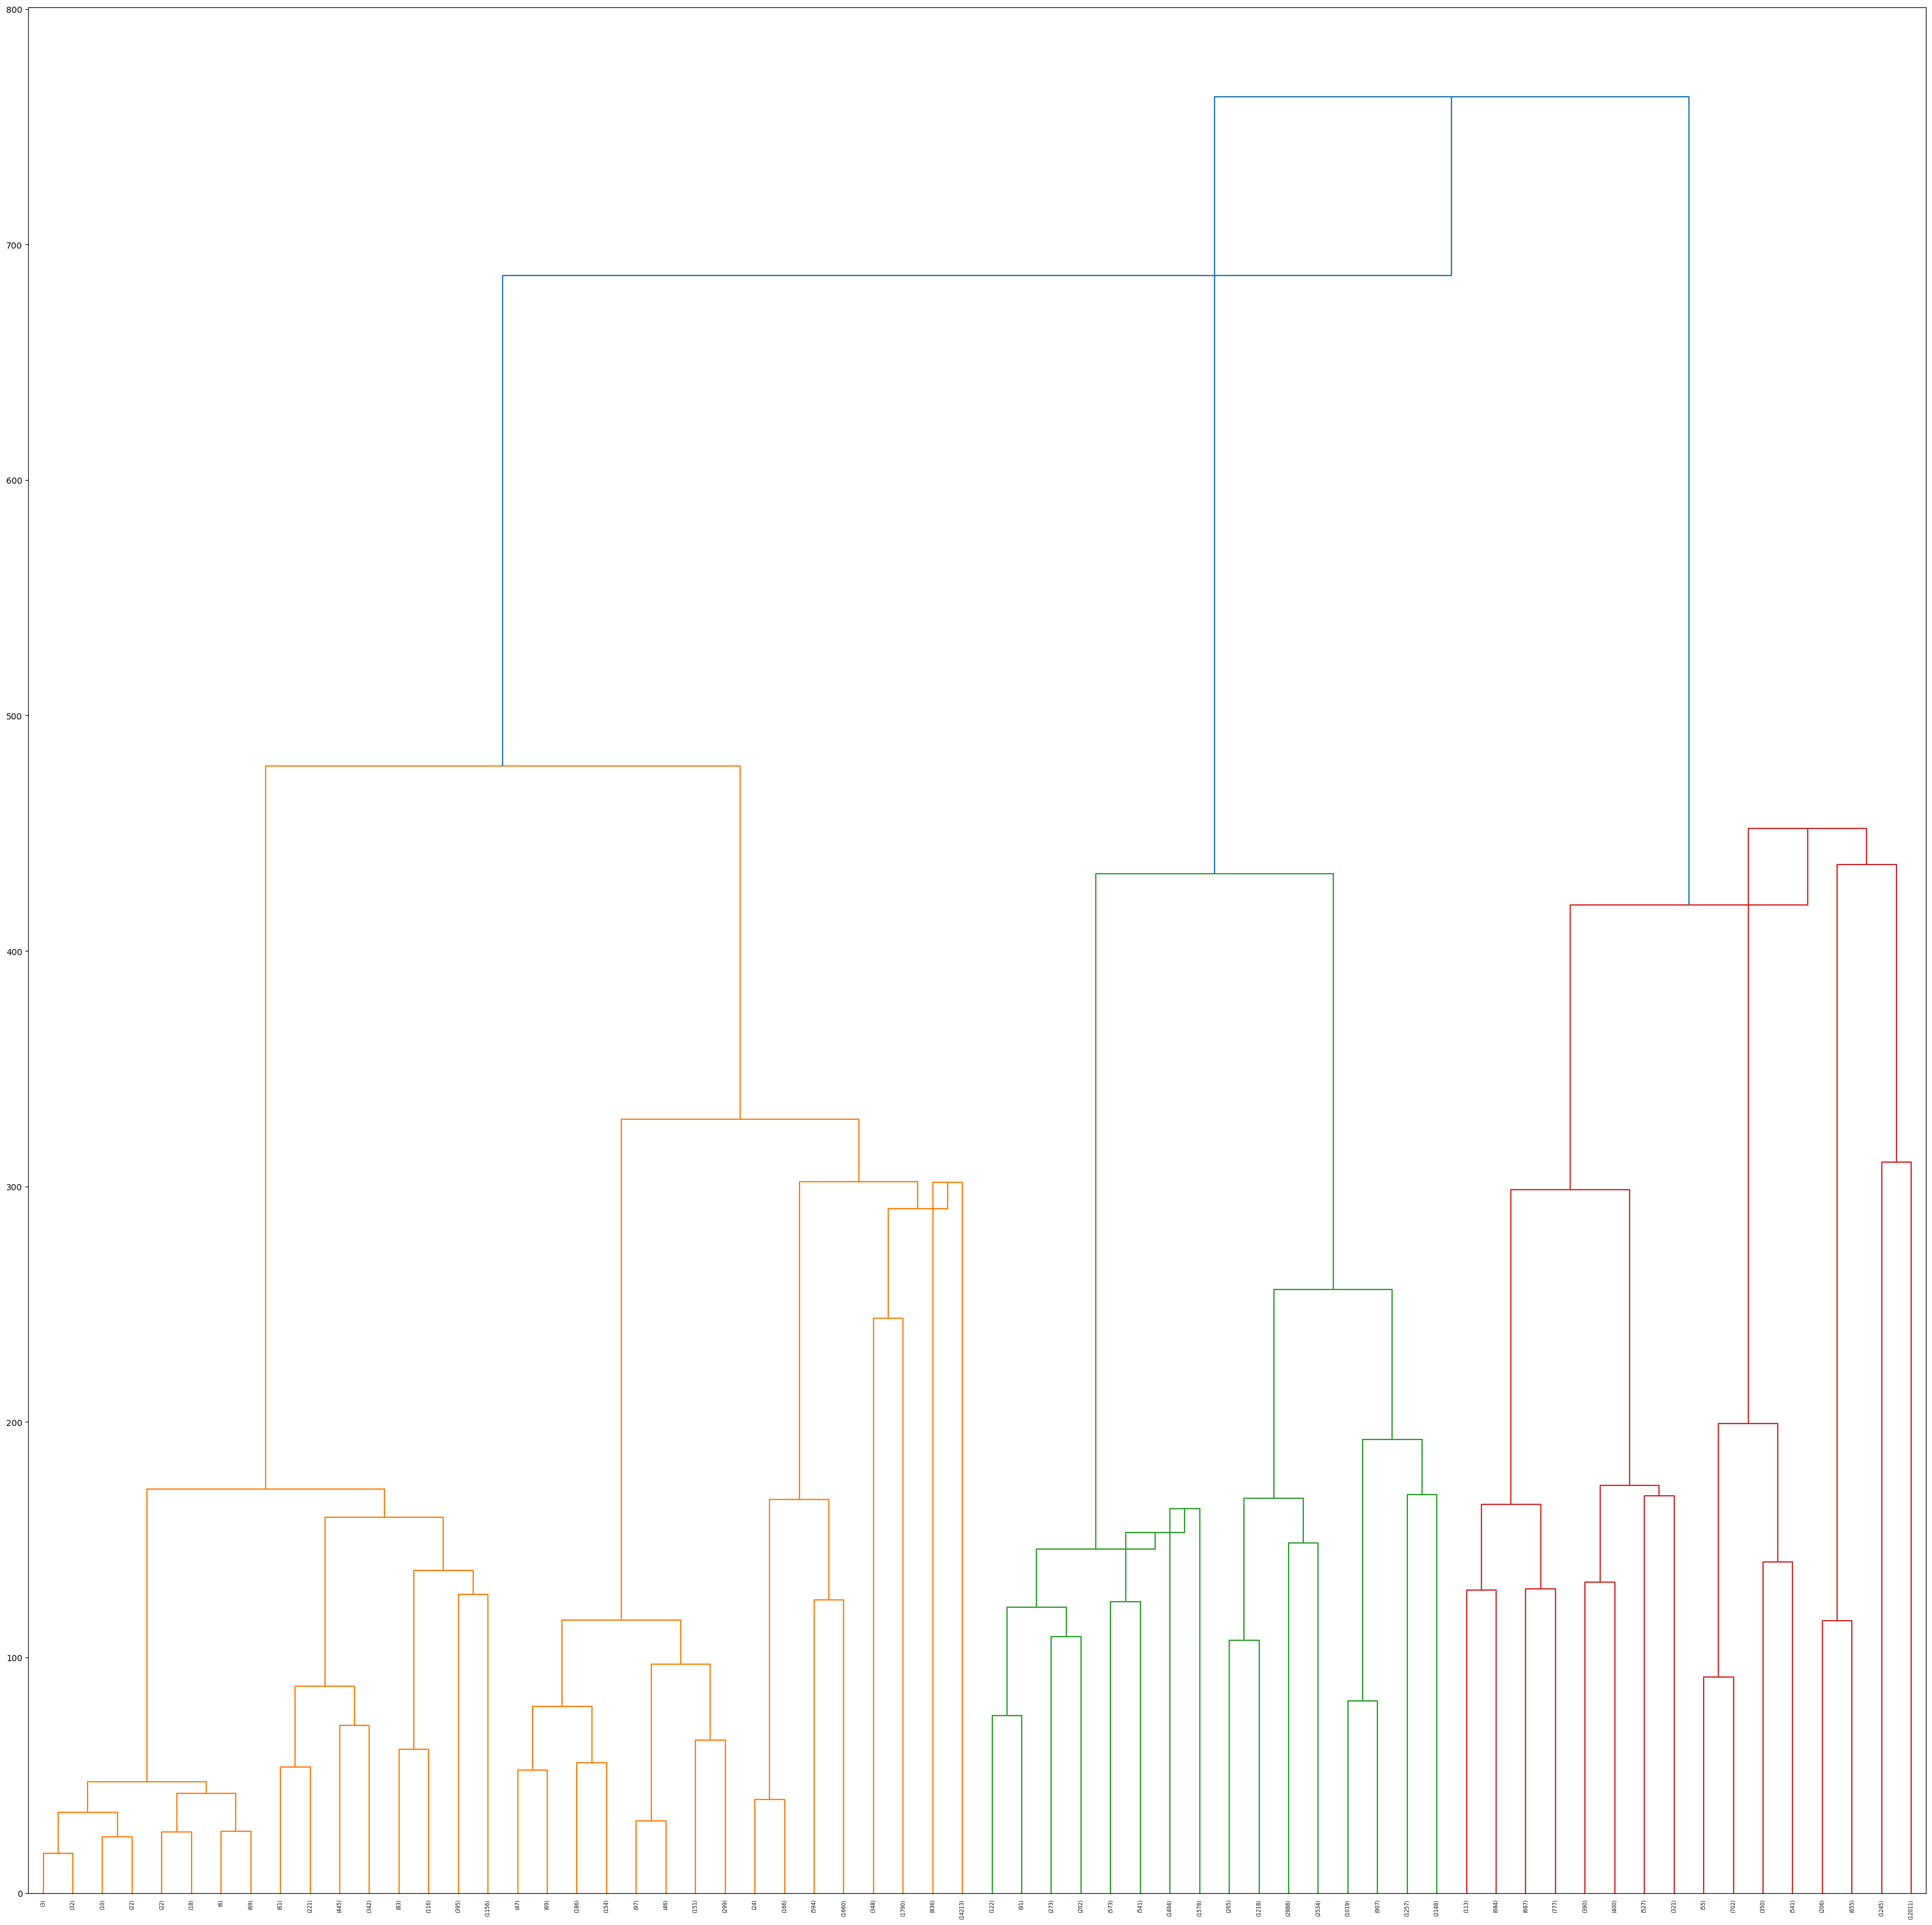

In [41]:
fix, ax = plt.subplots(figsize=(40,40))
# Plot the corresponding dendrogram
_ = dendrogram(linkage_matrix, truncate_mode="level", p=5, ax=ax)

In [42]:
from sklearn.metrics import calinski_harabasz_score

In [43]:
tess_groups = generate_neigbhourhood_groups(tessellation,
                                            buffer=200,
                                         include_random_sample=True,
                                         random_sample_size=1_000)
tess_groups = tess_groups[tess_groups.index.isin(training_data.index)]
tess_groups_ilocs = (
    pd.Series(np.arange(len(training_data)), index=training_data.index)
    .loc[tess_groups.index]
    .values
)

In [44]:
for t in range(25, 600, 25):
    r = fcluster(linkage_matrix, t=t, criterion='distance')
    # r = pd.Series(r, index=X_train.index)
    # # ssplits = graph.describe(r, statistics=['nunique'])['nunique']
    print(t, ' - ', 
          adjusted_rand_score(tess_groups.values, r[tess_groups_ilocs]),
          # (ssplits > 1).sum() / ssplits.shape[0],
          davies_bouldin_score(training_data, r),
          calinski_harabasz_score(training_data, r)
         )

25  -  0.2337251831181163 2.14859919806135 65.14119617569855
50  -  0.4674684928624393 2.834613247636257 134.97657193139634
75  -  0.5731903842813182 3.3063940363630038 210.10623407462103
100  -  0.6136356248654944 3.7434556562881793 296.95984112601496
125  -  0.7133769417599995 4.210061463048113 391.0989681136565
150  -  0.7111286907360066 4.418101035539661 477.1120392574178
175  -  0.7081766321479659 4.659781383939673 625.1217242966504
200  -  0.6053341597047659 5.296895796993557 782.6459730181498
225  -  0.5417881233327632 5.23686283486903 964.3560343780125
250  -  0.538201216921286 5.257267434524574 1030.3077240051546
275  -  0.37793314841292586 5.289912607789558 1066.7539515114793
300  -  0.38272935353742427 5.666485366026512 1183.762364581224
325  -  0.3792834775309185 6.105310803444791 1469.2844849007433
350  -  0.3012344347178015 6.521351721775555 1579.41621804841
375  -  0.3012344347178015 6.521351721775555 1579.41621804841
400  -  0.3012344347178015 6.521351721775555 1579.416

In [99]:
clusters = fcluster(linkage_matrix, t=200, criterion='distance')

In [45]:
plotting = tessellation.loc[training_data.index].reset_index()

In [46]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.PolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 1.16 s, sys: 96.1 ms, total: 1.26 s
Wall time: 1.26 s


In [47]:
from sidecar import Sidecar
sc = Sidecar(title='Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

Map(basemap_style=<CartoBasemap.Positron: 'https://basemaps.cartocdn.com/gl/positron-gl-style/style.json'>, la…

In [48]:
from core.cluster_validation import get_color

In [49]:
clusters = fcluster(linkage_matrix, t=150, criterion='distance')

In [50]:
np.unique(clusters, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61], dtype=int32),
 array([ 182, 1069, 1750, 1049,  190, 2254,  348, 1790,  339,  497,  858,
         304,  161,  398,  203, 1896,  390,  930, 1238, 1814,  182,  855,
        1506,  216, 1769,  273,  377,  480,  363,  688, 1114, 1494,  642,
         936, 1483, 5522, 1926, 1257, 2148,  797, 1464,  790,  527,  321,
         757,  891,  861,  536,  709, 1641,  524, 2189,  481, 1436,  246,
         717,  493,  654,  547,  300, 2783]))

In [51]:
layer.get_fill_color = get_color(clusters)

In [ ]:
from core.cluster_validation import get_feature_importance
from core.utils import used_keys

In [69]:
clusters_subset = [11597, 11615, 17742]
clusters_subset = np.where(np.isin(clusters, clusters[clusters_subset]))

In [70]:
imps = get_feature_importance(training_data.iloc[clusters_subset], clusters[clusters_subset])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [72]:
imps.loc[:10, [c for c in imps.columns if '_vals' not in c]]

,cluster_48,cluster_66,cluster_69
0,linWID_higher,lcdMes_higher,ssbCCD_lower
1,ldsMSL_lower,linPDE,ltkOri_lower
2,lddNDe,linP3W_higher,ssbSqu_lower
3,ltkOri_lower,mtbAli_median,lcdMes_median
4,ldsMSL,lskCWA_lower,linWID_higher
5,ldsMSL_median,lskERI_median,sicCAR_lower
6,midRea_median,ltkWNB_median,lskCWA_lower
7,ldkAre_higher,linWID_lower,stcOri_lower
8,lskCCo_lower,mtbNDi_higher,ssbSqu_median
9,ssbCCD_lower,linPDE_lower,sdcLAL_median


In [77]:
used_keys['ltkOri']

'orientation of enclosure'

In [112]:
imps = get_feature_importance(training_data, clusters)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 co

In [119]:
imps.loc[:10, [c for c in imps.columns if '_vals' not in c]]

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
0,ldkPer,lcdMes,libNCo,lskCWA,ldsAre,ltkWNB,likWBB
1,ltkWNB,likWBB,likWBB,likWBB,midAre,ldkPer,lcdMes
2,lskCCo,ltkWNB,sdsSPO,ltkWNB,ltkOri,lskCCo,ltkWNB
3,ltkOri,lskERI,ldbPWL,lskCCo,linP4W,lskCWA,linWID
4,lskCWA,lskCWA,ltcBuA,ldkAre,sdsSPO,ltkOri,ltkOri
5,ldkAre,ldkAre,sicCAR,lskERI,ldsMSL,likWBB,lskCWA
6,likWBB,linP4W,mtbSWR,ldsAre,lddNDe,ldkAre,ldkAre
7,lcdMes,ldkPer,ssbSqu,lddNDe,lcdMes,lskERI,lddNDe
8,lskERI,ltkOri,lskERI,midRea,ldkPer,linP3W,linP3W
9,linP4W,linPDE,sdbPer,linPDE,likWBB,ldsAre,lcnClo


In [122]:
used_keys['lcdMes']

'local meshedness of street network'

In [ ]:
imps[[c for c in imps.columns if '_vals' in c]].cumsum(axis=1)

In [96]:
josefov_joins = []

josefov_joins.append(np.isin(linkage_matrix[:, 0], 
                             tess_groups_ilocs[tess_groups == 'josefov']))
josefov_joins.append(np.isin(linkage_matrix[:, 1], 
                             tess_groups_ilocs[tess_groups == 'josefov']))


In [97]:
indxs = linkage_matrix[josefov_joins[0] | josefov_joins[1]]
indxs = np.union1d(indxs[:, 0], indxs[:, 1])
indxs = indxs[indxs <= X_train.shape[0]]

In [150]:
indxs = linkage_matrix[linkage_matrix[:, 2] <= 2]
indxs = np.union1d(indxs[:, 0], indxs[:, 1])
indxs = indxs[indxs < X_train.shape[0]]
indxs.shape

(64349,)

In [151]:
plotting = tessellation.loc[X_train.iloc[indxs].index]

In [42]:
cluster_means = training_data.groupby(clusters).mean()

In [68]:
c1 = 6
c2 = 10

(cluster_means.loc[c1] - cluster_means.loc[c2]).sort_values(ascending=False)

libNCo           6.284668
libNCo_median    5.846288
libNCo_higher    4.233946
linPDE_higher    3.014914
linPDE           2.122206
                   ...   
lcnClo          -1.414220
linWID_lower    -1.422183
linP3W          -1.489277
lcnClo_lower    -1.702326
linP3W_lower    -2.339139
Length: 248, dtype: float64

In [72]:
from core.utils import used_keys
used_keys['libNCo']

'number of courtyards within adjacent buildings'

In [169]:
bgraph = read_parquet(graph_dir + f"building_graph_{region_id}_knn1.parquet")

In [170]:
buildings_dir = '/data/uscuni-ulce/processed_data/buildings/'

buildings = gpd.read_parquet(
        buildings_dir + f"buildings_{region_id}.parquet"

)

In [178]:
buildings

,index,id,geometry
0,0,v0.1-CZE.12.2_1-35164,"POLYGON ((4614847.626 2975218.938, 4614848.235..."
1,1,v0.1-CZE.12.2_1-35123,"POLYGON ((4615276.357 2976034.184, 4615282.866..."
2,2,v0.1-CZE.12.2_1-35159,"POLYGON ((4615315.503 2975986.2, 4615322.056 2..."
3,3,v0.1-CZE.12.2_1-35166,"POLYGON ((4615222.339 2976016.91, 4615224.582 ..."
4,4,v0.1-CZE.12.2_1-35228,"POLYGON ((4615300.348 2975924.258, 4615301.6 2..."
...,...,...,...
299059,299060,v0.1-CZE.13.3_1-13696,"POLYGON ((4618611.169 3033535.197, 4618623.01 ..."
299060,299061,v0.1-CZE.13.3_1-13674,"POLYGON ((4618611.989 3033568.153, 4618617.119..."
299061,299062,v0.1-CZE.13.3_1-13591,"POLYGON ((4618614.831 3033550.704, 4618628.289..."
299062,299063,v0.1-CZE.13.3_1-13328,"POLYGON ((4618625.628 3033512.926, 4618625.634..."


In [181]:
buildings = buildings.join(X_train, how='inner').drop(['index', 'id'], axis=1)

In [185]:
r = buildings.dissolve(bgraph.component_labels, aggfunc='mean')

In [189]:
plotting = r

In [190]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.PolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 1.65 s, sys: 178 ms, total: 1.83 s
Wall time: 1.82 s


In [191]:
from sidecar import Sidecar
sc = Sidecar(title='Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)